In [1]:
using StatsPlots
using Random: MersenneTwister
using StatsBase: mean, std, cor

include("../src/Simulation.jl")
using .Simulation: Param, Model, run!, C_rate, Strategy, C, D

include("../src/Network.jl")
using .Network: mat_degree

include("../src/ColorScheme.jl")
using .ColorScheme
const CS = ColorScheme

println("Julia $(VERSION)")
println("Thread count: $(Threads.nthreads())")

Julia 1.10.2
Thread count: 12


In [2]:
function create_param(; b::Float64 = 1.8, σR::Int = 0, β::Float64 = 0.0, σθ::Float64 = 0.0)::Param
    return Param(
        N = 100,
        k₀ = 4,
        generations = 10_000,
        C_rate₀ = 0.0,
        relationship_increment_factor = 1.0,
        resource_decrement_factor = 0.02,
        resource_limit_μ = 0.5,
        b = b,
        peak_node_variability = σR,
        resource_limit_β = β,
        resource_limit_σ = σθ,
    )
end

function calc_prime_node_shift_vec(prime_node_vec::Vector{Int}, N::Int = 100)::Vector{Float64}
    env_var_vec = abs.(prime_node_vec[2:end] .- prime_node_vec[1:(end-1)])

    return Float64.([x > Int(N / 2) ? N - x : x for x in env_var_vec])
end

function calc_mean_resource_diff(strategy_vec::Vector{Strategy}, resource_vec::Vector{Float64})::Float64
    C_mean_resouce = mean(resource_vec[findall(==(C), strategy_vec)])
    D_mean_resouce = mean(resource_vec[findall(==(D), strategy_vec)])
    C_mean_resouce = isnan(C_mean_resouce) ? 0.0 : C_mean_resouce
    D_mean_resouce = isnan(D_mean_resouce) ? 0.0 : D_mean_resouce
    return C_mean_resouce - D_mean_resouce
end

function calc_mean_degree_diff(strategy_vec::Vector{Strategy}, degree_vec::Vector{Int})::Float64
    C_mean_degree = mean(degree_vec[findall(==(C), strategy_vec)])
    D_mean_degree = mean(degree_vec[findall(==(D), strategy_vec)])
    C_mean_degree = isnan(C_mean_degree) ? 0.0 : C_mean_degree
    D_mean_degree = isnan(D_mean_degree) ? 0.0 : D_mean_degree
    return C_mean_degree - D_mean_degree
end

function clear_memory!(obj::AbstractVector)::Nothing
    println("$(round(Base.summarysize(obj) / 1024 / 1024)) MB is used.")
    empty!(obj)
    resize!(obj, 0)
    GC.gc()
    println("$(round(Base.summarysize(obj) / 1024 / 1024)) MB is used after clearing.")

    return
end;

In [3]:
trials = 100

# Execute simulations (Regional Variability)
p_regional = create_param(b = 1.8, σR = 16)
m_regional_vec_vec = []

for _ in 1:trials
    rng = MersenneTwister(rand(1:typemax(Int16)))
    m = Model(p_regional, rng)
    model_vec = run!(m, rng, :full)
    push!(m_regional_vec_vec, model_vec)
end;

In [4]:
# Variables (Regional Variability)
r_C_rate_vec_vec = [[C_rate(m) for m in model_vec] for model_vec in m_regional_vec_vec]
r_degree_vec_vec_vec = [[mat_degree(m.relation_mat) for m in model_vec] for model_vec in m_regional_vec_vec]
r_prime_node_vec_vec = [[m.peak_node for m in model_vec] for model_vec in m_regional_vec_vec]
r_strategy_vec_vec_vec = [[m.strategy_vec for m in model_vec] for model_vec in m_regional_vec_vec]
r_resource_vec_vec_vec = [[m.resource_vec for m in model_vec] for model_vec in m_regional_vec_vec]

clear_memory!(m_regional_vec_vec)

r_C_rate_var_vec_vec = [C_rate_vec[2:end] .- C_rate_vec[1:(end-1)] for C_rate_vec in r_C_rate_vec_vec]
r_env_var_vec_vec = [calc_prime_node_shift_vec(prime_node_vec) for prime_node_vec in r_prime_node_vec_vec]
r_degree_SD_vec_vec = [[std(degree_vec) for degree_vec in degree_vec_vec] for degree_vec_vec in r_degree_vec_vec_vec]
r_hub_count_vec_vec = [[Float64(sum(degree_vec .>= 10)) for degree_vec in degree_vec_vec] for degree_vec_vec in r_degree_vec_vec_vec]
r_mean_resource_diff_vec_vec =  [[calc_mean_resource_diff(s_vec, r_vec) for (s_vec, r_vec) in zip(s_vec_vec, r_vec_vec)] for (s_vec_vec, r_vec_vec) in zip(r_strategy_vec_vec_vec, r_resource_vec_vec_vec)]
r_mean_degree_diff_vec_vec = [[calc_mean_degree_diff(s_vec, d_vec) for (s_vec, d_vec) in zip(s_vec_vec, d_vec_vec)] for (s_vec_vec, d_vec_vec) in zip(r_strategy_vec_vec_vec, r_degree_vec_vec_vec)];

154060.0 MB is used.
0.0 MB is used after clearing.


In [5]:
# Execute simulations (Universal Variability)
p_universal = create_param(b = 1.8, β = 0.7, σθ = 0.1)
m_universal_vec_vec = []

for _ in 1:trials
    rng = MersenneTwister(rand(1:typemax(Int16)))
    m = Model(p_universal, rng)
    model_vec = run!(m, rng, :full)
    push!(m_universal_vec_vec, model_vec)
end;

In [6]:
# Variables (Universal Variability)
u_C_rate_vec_vec = [[C_rate(m) for m in model_vec] for model_vec in m_universal_vec_vec]
u_degree_vec_vec_vec = [[mat_degree(m.relation_mat) for m in model_vec] for model_vec in m_universal_vec_vec]
u_θ_vec_vec = [model_vec[1].resource_limit_vec for model_vec in m_universal_vec_vec]
u_strategy_vec_vec_vec = [[m.strategy_vec for m in model_vec] for model_vec in m_universal_vec_vec]
u_resource_vec_vec_vec = [[m.resource_vec for m in model_vec] for model_vec in m_universal_vec_vec]

clear_memory!(m_universal_vec_vec)

u_C_rate_var_vec_vec = [C_rate_vec[2:end] .- C_rate_vec[1:(end-1)] for C_rate_vec in u_C_rate_vec_vec]
u_env_var_vec_vec = [θ_vec[2:end] .- θ_vec[1:(end-1)] for θ_vec in u_θ_vec_vec]
u_degree_SD_vec_vec = [[std(degree_vec) for degree_vec in degree_vec_vec] for degree_vec_vec in u_degree_vec_vec_vec]
u_hub_count_vec_vec = [[Float64(sum(degree_vec .>= 10)) for degree_vec in degree_vec_vec] for degree_vec_vec in u_degree_vec_vec_vec]
u_mean_resource_diff_vec_vec =  [[calc_mean_resource_diff(s_vec, r_vec) for (s_vec, r_vec) in zip(s_vec_vec, r_vec_vec)] for (s_vec_vec, r_vec_vec) in zip(u_strategy_vec_vec_vec, u_resource_vec_vec_vec)]
u_mean_degree_diff_vec_vec = [[calc_mean_degree_diff(s_vec, d_vec) for (s_vec, d_vec) in zip(s_vec_vec, d_vec_vec)] for (s_vec_vec, d_vec_vec) in zip(u_strategy_vec_vec_vec, u_degree_vec_vec_vec)];

154060.0 MB is used.
0.0 MB is used after clearing.


In [7]:
function moving_average(data::Vector{<:Real}, window_size::Int = 10)::Vector{Float64}
    return if window_size > 0
        [mean(data[max(1, i-window_size):min(end, i+window_size)]) for i in 1:length(data)]
    else
        Float64.(data)
    end
end

function calc_cor(x_vec_vec::Vector{Vector{Float64}}, y_vec_vec::Vector{Vector{Float64}}, moving_average_window_size::Int = 10)::Tuple{Float64, Float64}
    _x_vec_vec = [moving_average(x_vec, moving_average_window_size) for x_vec in x_vec_vec]
    _y_vec_vec = [moving_average(y_vec, moving_average_window_size) for y_vec in y_vec_vec]

    if length(_y_vec_vec[1]) - length(_x_vec_vec[1]) == 1
        _y_vec_vec = [_y_vec[2:end] for _y_vec in _y_vec_vec]
    end

    cor_vec = [cor(x_vec, y_vec) for (x_vec, y_vec) in zip(_x_vec_vec, _y_vec_vec)]

    return mean(cor_vec), std(cor_vec)
end;

In [8]:
default(
    fontfamily="Arial",
    titlefontsize=16,
    guidefontsize=14,
    tickfontsize=11,
    legendfontsize=11,
    margin=5Plots.mm,
    foreground_color_legend = nothing,
    background_color_legend = nothing,
    linewidth=1,
    dpi=600,
);

In [9]:
label_vec = [
    "(env,\ndegree SD)",
    "(env,\nhub count)",
    "(env,\nC rate)",
    "(C rate,\ndegree SD)",
    "(C rate,\nhub count)",
    "(C rate,\ndegree diff)",
    "(C rate,\nresource diff)",
    "(resource diff,\ndegree diff)",
]

r_variable_pair_vec = [
    (r_env_var_vec_vec, r_degree_SD_vec_vec),
    (r_env_var_vec_vec, r_hub_count_vec_vec),
    (r_env_var_vec_vec, r_C_rate_vec_vec),
    (r_C_rate_vec_vec, r_degree_SD_vec_vec),
    (r_C_rate_vec_vec, r_hub_count_vec_vec),
    (r_C_rate_vec_vec, r_mean_degree_diff_vec_vec),
    (r_C_rate_vec_vec, r_mean_resource_diff_vec_vec),
    (r_mean_resource_diff_vec_vec, r_mean_degree_diff_vec_vec),
]

r_mean_cor_vec = []
r_std_cor_vec = []

for (x, y) in r_variable_pair_vec
    mean_cor, std_cor = calc_cor(x, y)
    push!(r_mean_cor_vec, mean_cor)
    push!(r_std_cor_vec, std_cor)
end

u_variable_pair_vec = [
    (u_θ_vec_vec, u_degree_SD_vec_vec),
    (u_θ_vec_vec, u_hub_count_vec_vec),
    (u_θ_vec_vec, u_C_rate_vec_vec),
    (u_C_rate_vec_vec, u_degree_SD_vec_vec),
    (u_C_rate_vec_vec, u_hub_count_vec_vec),
    (u_C_rate_vec_vec, u_mean_degree_diff_vec_vec),
    (u_C_rate_vec_vec, u_mean_resource_diff_vec_vec),
    (u_mean_resource_diff_vec_vec, u_mean_degree_diff_vec_vec),
]

u_mean_cor_vec = []
u_std_cor_vec = []

for (x, y) in u_variable_pair_vec
    mean_cor, std_cor = calc_cor(x, y)
    push!(u_mean_cor_vec, mean_cor)
    push!(u_std_cor_vec, std_cor)
end;

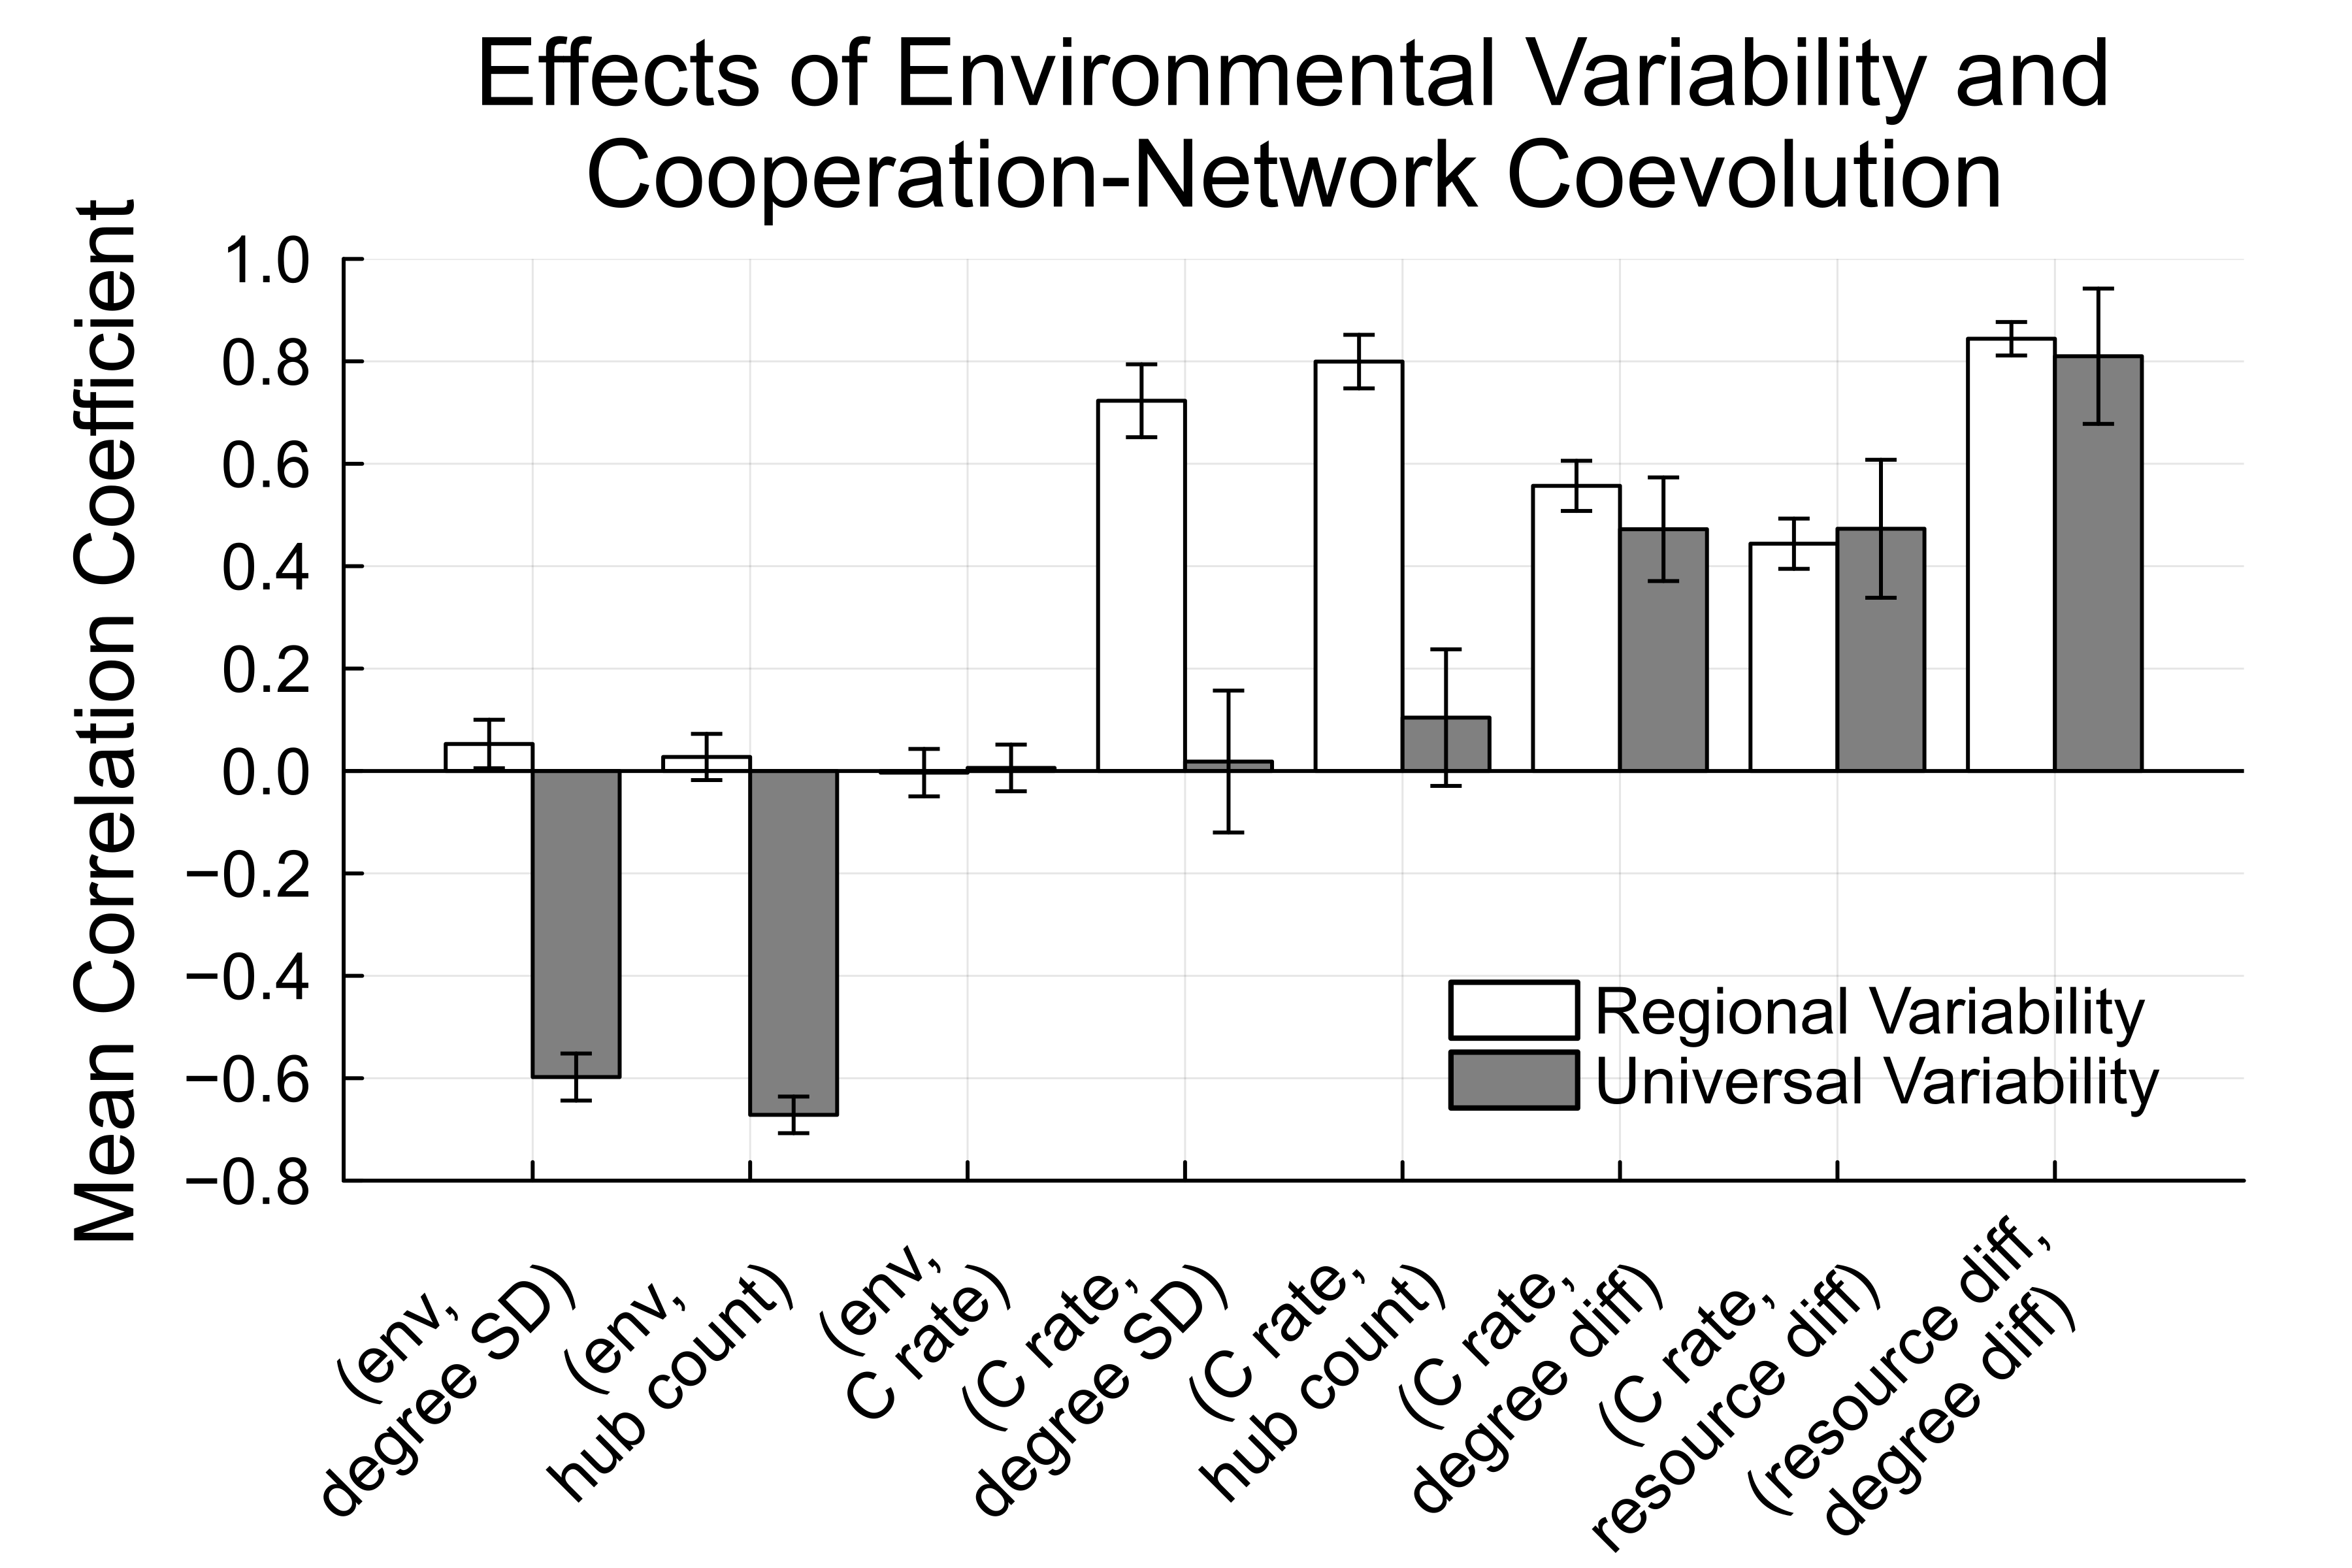

In [10]:
# groupedbarでグループ化された棒グラフをプロット
plt = groupedbar(label_vec, [r_mean_cor_vec u_mean_cor_vec],
    yerr=[r_std_cor_vec u_std_cor_vec], 
    bar_position=:dodge,
    bar_width=0.8, 
    label=["Regional Variability" "Universal Variability"], 
    color=[:white :gray],
    xrotation=45,
    ylabel="Mean Correlation Coefficient",
    ylim=(-0.8, 1),
    yticks=-1:0.2:1,
    title="Effects of Environmental Variability and\nCooperation-Network Coevolution",
    legend=:bottomright,
)
hline!([0], color=:black, label=false)
# savefig(plt, "img/Fig5b.png")
plt

In [11]:
default(
    fontfamily="Arial",
    titlefontsize=14,
    guidefontsize=11,
    tickfontsize=11,
    legendfontsize=11,
    margin=5Plots.mm,
    foreground_color_legend = nothing,
    background_color_legend = :white,
    linewidth=1,
    dpi=600,
);

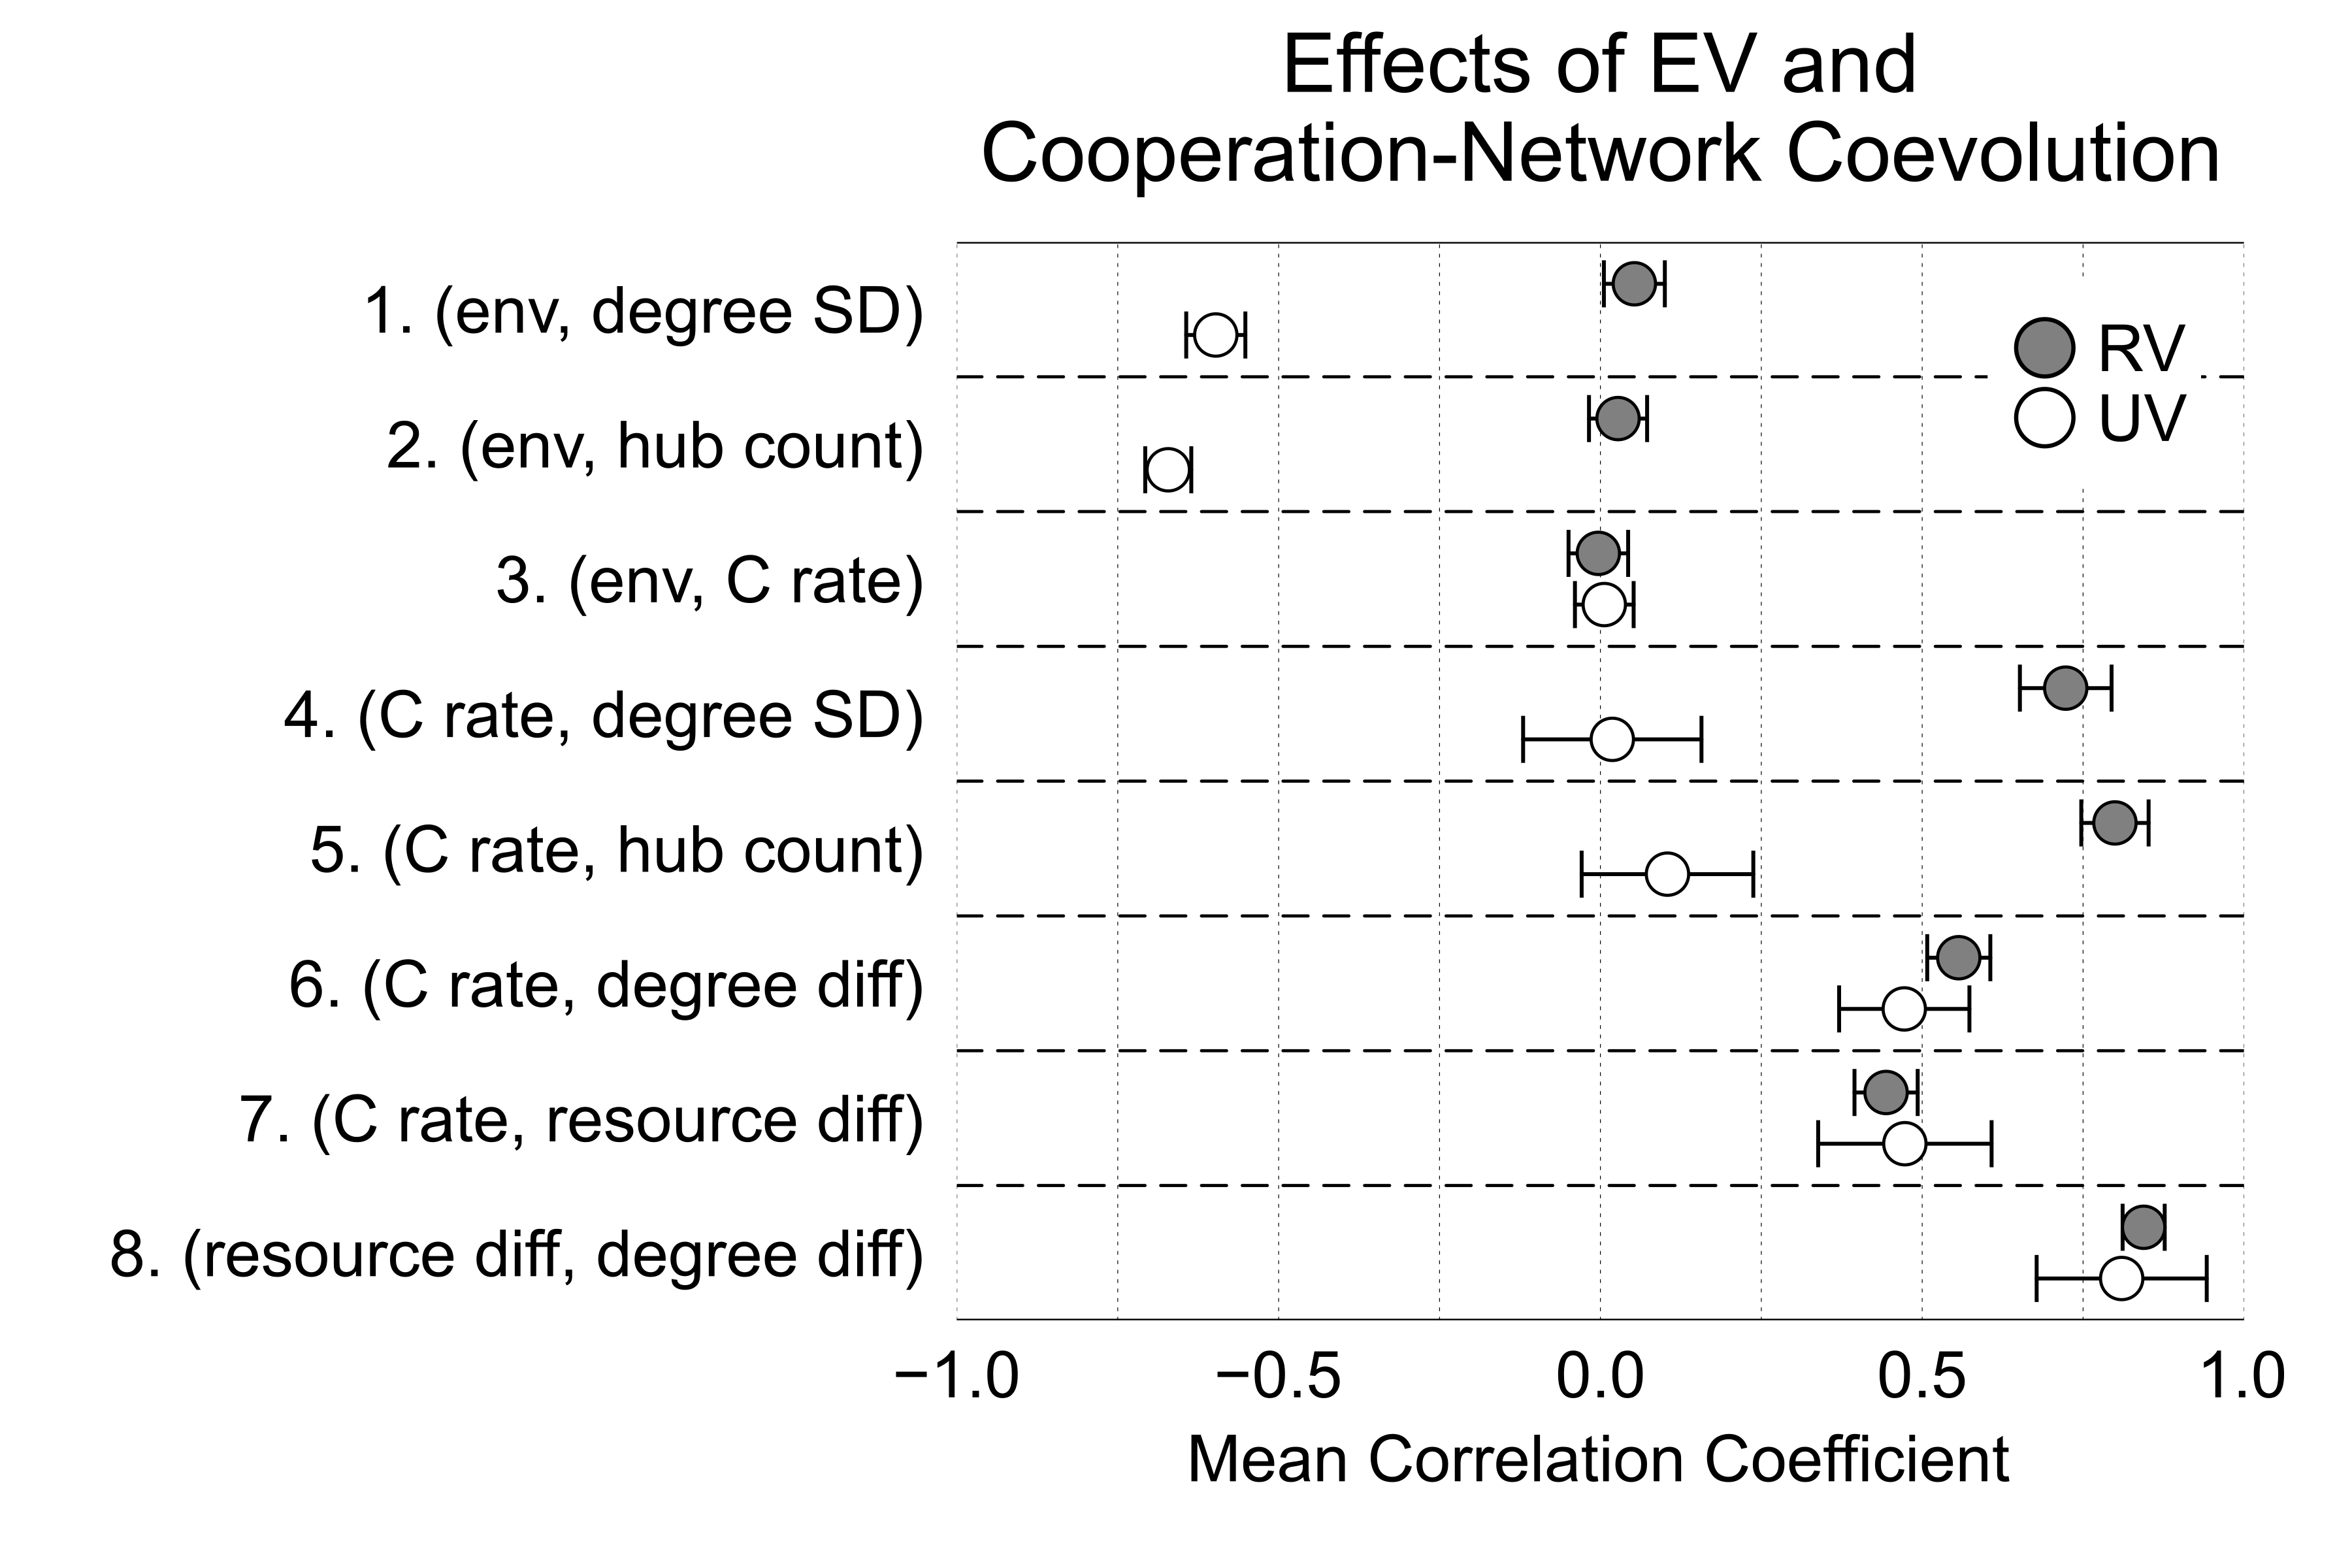

In [12]:
label_vec = [
    "1. (env, degree SD)",
    "2. (env, hub count)",
    "3. (env, C rate)",
    "4. (C rate, degree SD)",
    "5. (C rate, hub count)",
    "6. (C rate, degree diff)",
    "7. (C rate, resource diff)",
    "8. (resource diff, degree diff)",
]

label_position_vec = (length(label_vec) - 0.5):-1:0.5

plt = plot(
    title="Effects of EV and\nCooperation-Network Coevolution",
    orientation=:h,
    xlabel="Mean Correlation Coefficient",
    xlim=(-1, 1),
    xticks=-1:0.5:1,
    ylim=(0, 8),
    yticks=(label_position_vec, label_vec),
    framestyle=:grid,
    grid=false,
    legend=:topright,
)
hline!(1:1:7, lc=:black, lw=0.8, ls=:dash, label=false)
hline!([0, 8], lc=:black, lw=0.8, label=false)
vline!(-1:0.25:1, lc=:black, lw=0.2, ls=:dot, label=false)

scatter!(r_mean_cor_vec, label_position_vec .+ 0.19, xerr=r_std_cor_vec, label="RV", color=:gray, markershape=:circle, markersize=6)
scatter!(u_mean_cor_vec, label_position_vec .- 0.19, xerr=u_std_cor_vec, label="UV", color=:white, markershape=:circle, markersize=6)
savefig(plt, "img/Fig5b.png")
plt